Root folders found: ['damaged', 'undamaged']
✅ Success! Found 1237 damaged images.


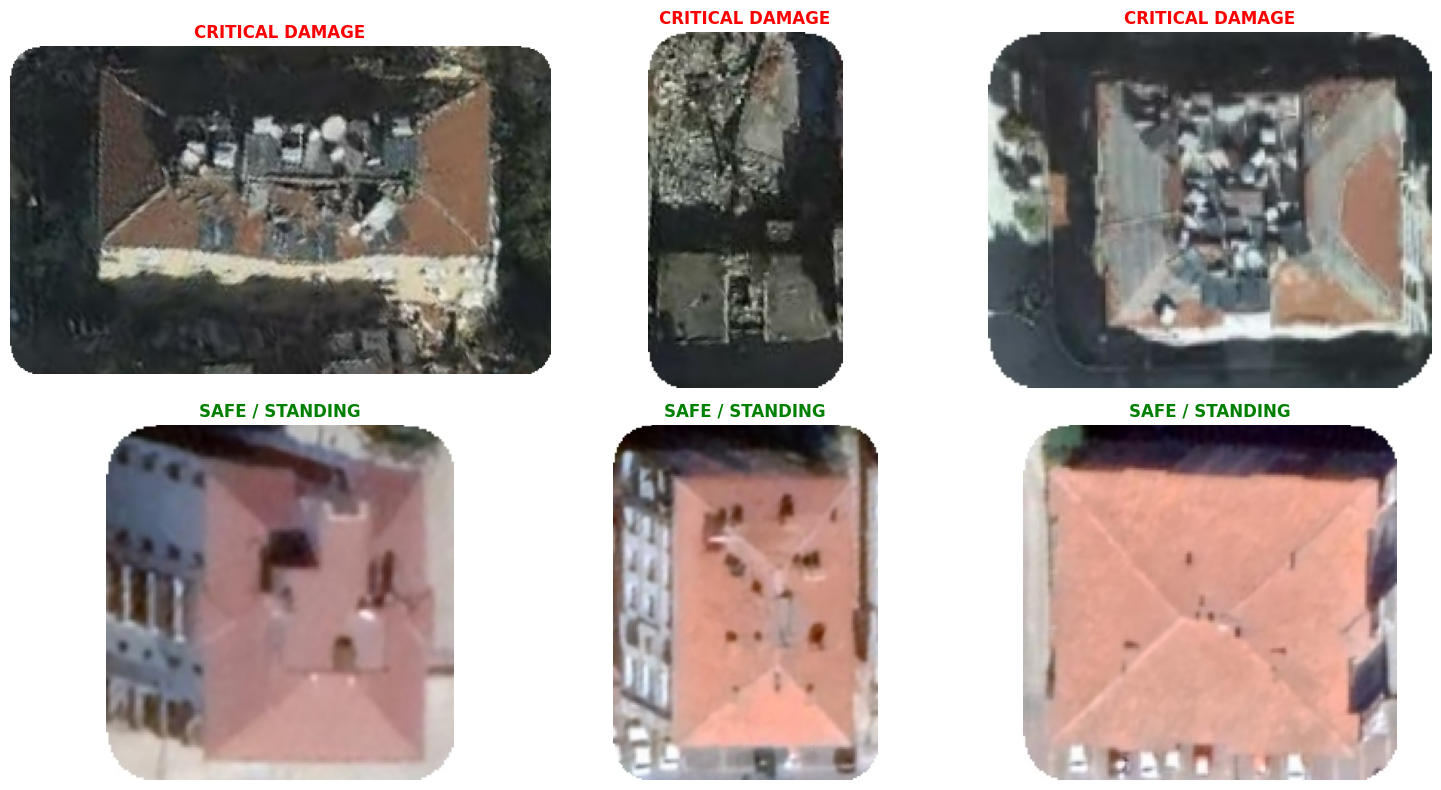

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

# 1. Define the Path (Kaggle automatically mounts datasets here)
dataset_path = '/kaggle/input/turkiye-earthquake-2023-damaged-buildings'

# 2. Check internal folders (sometimes they are nested)
print("Root folders found:", os.listdir(dataset_path))

# 3. Define the specific sub-folders
damaged_dir = os.path.join(dataset_path, 'damaged')
undamaged_dir = os.path.join(dataset_path, 'undamaged')

# 4. Get lists of images
try:
    damaged_files = os.listdir(damaged_dir)[:3]
    undamaged_files = os.listdir(undamaged_dir)[:3]
    print(f"✅ Success! Found {len(os.listdir(damaged_dir))} damaged images.")
except FileNotFoundError:
    print("❌ Error: Could not find the folders. Check the print statement above.")

# 5. Visualize the Images
plt.figure(figsize=(15, 8))

# Show 3 Damaged Images
for i, file_name in enumerate(damaged_files):
    img_path = os.path.join(damaged_dir, file_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title("CRITICAL DAMAGE", color='red', fontweight='bold')
        plt.axis("off")

# Show 3 Safe Images
for i, file_name in enumerate(undamaged_files):
    img_path = os.path.join(undamaged_dir, file_name)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i+4)
        plt.imshow(img)
        plt.title("SAFE / STANDING", color='green', fontweight='bold')
        plt.axis("off")

plt.tight_layout()
plt.show()

In [2]:
# 1. Install YOLOv8 (Ultralytics)
%pip install ultralytics -q
import os
import shutil
import random
from ultralytics import YOLO

# 2. Setup Data Structure for YOLO (Train/Val Split)
# Kaggle input is read-only, so we copy data to /kaggle/working/
print("⚙️ Setting up training workspace...")

base_dir = '/kaggle/working/hayat_data'
if os.path.exists(base_dir):
    shutil.rmtree(base_dir) # Clean up if re-running

# Create folders: train/damaged, train/undamaged, val/damaged, val/undamaged
for split in ['train', 'val']:
    for category in ['damaged', 'undamaged']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# 3. Split and Copy Files (80% Train, 20% Validation)
source_root = '/kaggle/input/turkiye-earthquake-2023-damaged-buildings'
categories = ['damaged', 'undamaged']

for category in categories:
    src_path = os.path.join(source_root, category)
    files = [f for f in os.listdir(src_path) if f.endswith('.jpg')]
    random.shuffle(files)
    
    split_idx = int(len(files) * 0.8) # 80% split
    train_files = files[:split_idx]
    val_files = files[split_idx:]
    
    # Copy files (This takes a few seconds)
    print(f"   Copying {len(train_files)} images to TRAIN and {len(val_files)} to VAL for class: {category}")
    for f in train_files:
        shutil.copy(os.path.join(src_path, f), os.path.join(base_dir, 'train', category, f))
    for f in val_files:
        shutil.copy(os.path.join(src_path, f), os.path.join(base_dir, 'val', category, f))

print("✅ Data setup complete!")

# 4. TRAIN THE MODEL
# We use 'yolov8n-cls.pt' (Nano Classification) - It is super fast and lightweight.
print("🚀 Starting Training (This may take 5-10 minutes)...")

model = YOLO('yolov8n-cls.pt') # Load pretrained model

results = model.train(
    data=base_dir,   # Location of our data
    epochs=10,       # How many rounds of learning
    imgsz=224,       # Standard image size
    project='/kaggle/working/runs',
    name='hayat_model'
)

print("🏆 Training Finished!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
⚙️ Setting up training workspace...
   Copying 989 images to TRAIN and 248 to VAL for class: damaged
   Copying 1198 images to TRAIN and 300 to VAL for class: undamaged
✅ Data setup complete!
🚀 Starting Training (This may take 5-10 minutes)...
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, cop


image 1/1 /kaggle/working/hayat_data/val/undamaged/2 (661).jpg: 224x224 undamaged 0.99, damaged 0.01, 2.6ms
Speed: 3.4ms preprocess, 2.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

🧠 AI PREDICTION: UNDAMAGED
📊 CONFIDENCE: 99.47%
🖼️ IMAGE: /kaggle/working/hayat_data/val/undamaged/2 (661).jpg


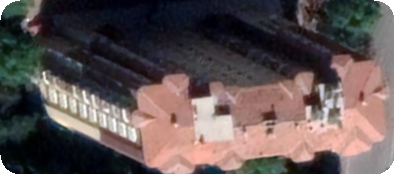

In [3]:
from ultralytics import YOLO
import glob
import random
from IPython.display import Image, display

# 1. Load your trained model
model = YOLO('/kaggle/working/runs/hayat_model/weights/best.pt')

# 2. Pick a random test image from the validation set
val_images = glob.glob('/kaggle/working/hayat_data/val/*/*.jpg')
test_image = random.choice(val_images)

# 3. Run Inference
results = model.predict(test_image)
result = results[0]
prediction = result.probs.top1
class_name = result.names[prediction]
confidence = result.probs.top1conf.item()

# 4. Show Result
print(f"\n🧠 AI PREDICTION: {class_name.upper()}")
print(f"📊 CONFIDENCE: {confidence:.2%}")
print(f"🖼️ IMAGE: {test_image}")
display(Image(filename=test_image, width=400))